Mnist plotting

In [1]:
import pandas as pd
US_data = pd.read_excel('./results/MNIST_7875_uncertanty_sampling.xlsx')
MAR_data = pd.read_excel('./results/MNIST_7875_margin_based.xlsx')
BADL_data = pd.read_excel('./results/MNIST_7875_bayesian.xlsx')
KMEANS_data = pd.read_excel('./results/MNIST_7875_kmeans.xlsx')

In [2]:
N = max(US_data.iloc[:,0])

In [3]:
import torch
import torchvision
import numpy as np
import pandas as pd
from copy import deepcopy
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt


In [4]:
### Hyperparameters
val_split = 0.1
unlabelled_size = 0.99
lr = 0.0005
batch_size = 64
num_epochs = 100
label_iterations = 150
torch.manual_seed(42)

In [5]:
### Setup MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [6]:
val_dataset = deepcopy(train_dataset)

In [7]:
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
indexes = torch.randperm(len(train_dataset)).tolist()
# Define validation set
indexes_val = indexes[train_size:]
val_dataset.targets = val_dataset.targets[indexes_val]
val_dataset.data = val_dataset.data[indexes_val]
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [8]:
# Define training set
indexes_train = indexes[:train_size]
train_dataset.targets = train_dataset.targets[indexes_train]
train_dataset.data = train_dataset.data[indexes_train]

In [9]:
# Split training data into labelled and unlabelled
unlabelled_size = int(unlabelled_size * len(train_dataset))
indexes_train = torch.randperm(len(train_dataset)).tolist()  # Redefine indexes_train
unlabbelled_dataset = deepcopy(train_dataset)
unlabbelled_dataset.targets = unlabbelled_dataset.targets[indexes_train[:unlabelled_size]]
unlabbelled_dataset.data = unlabbelled_dataset.data[indexes_train[:unlabelled_size]]
train_dataset.targets = train_dataset.targets[indexes_train[unlabelled_size:]]
train_dataset.data = train_dataset.data[indexes_train[unlabelled_size:]]
unlabbelled_dataset.targets = unlabbelled_dataset.targets
unlabbelled_dataset.data = unlabbelled_dataset.data
start_train_dataset = deepcopy(train_dataset)  # Save for baseline
start_unlabbelled_dataset = deepcopy(unlabbelled_dataset)  # Save for baseline

In [10]:
def validate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [11]:
# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
# Modify input layer to accept 1 channel
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model_parameters = deepcopy(model.state_dict())
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

c:\Users\soere\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\soere\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, val_interval=1):
    accuracies = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % val_interval == 0:
            val_accuracy = validate_model(model, val_loader, device)
            accuracies.append(val_accuracy)
            print(f'Epoch {epoch + 1}, Accuracy: {val_accuracy:.2f}%')
    return accuracies

In [13]:
# Add baseline accuracy (no active learning)
n_datapoints = N - len(start_train_dataset)
model.load_state_dict(model_parameters)
# We reuse the initial training set to reduce run to run variance
train_dataset.data = torch.cat([start_train_dataset.data, start_unlabbelled_dataset.data[:n_datapoints]])
train_dataset.targets = torch.cat([start_train_dataset.targets, start_unlabbelled_dataset.targets[:n_datapoints]])

In [14]:
# Train model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)
baseline_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)

 10%|█         | 10/100 [00:55<08:31,  5.68s/it]

Epoch 10, Accuracy: 97.62%


 20%|██        | 20/100 [02:00<09:57,  7.46s/it]

Epoch 20, Accuracy: 97.60%


 30%|███       | 30/100 [03:11<08:37,  7.39s/it]

Epoch 30, Accuracy: 98.25%


 40%|████      | 40/100 [04:25<07:23,  7.39s/it]

Epoch 40, Accuracy: 97.65%


 50%|█████     | 50/100 [05:41<06:51,  8.22s/it]

Epoch 50, Accuracy: 97.73%


 60%|██████    | 60/100 [06:54<05:15,  7.88s/it]

Epoch 60, Accuracy: 97.78%


 70%|███████   | 70/100 [08:08<03:36,  7.23s/it]

Epoch 70, Accuracy: 98.55%


 80%|████████  | 80/100 [09:27<02:45,  8.27s/it]

Epoch 80, Accuracy: 98.67%


 90%|█████████ | 90/100 [10:24<00:55,  5.51s/it]

Epoch 90, Accuracy: 97.65%


100%|██████████| 100/100 [11:15<00:00,  6.76s/it]

Epoch 100, Accuracy: 98.38%


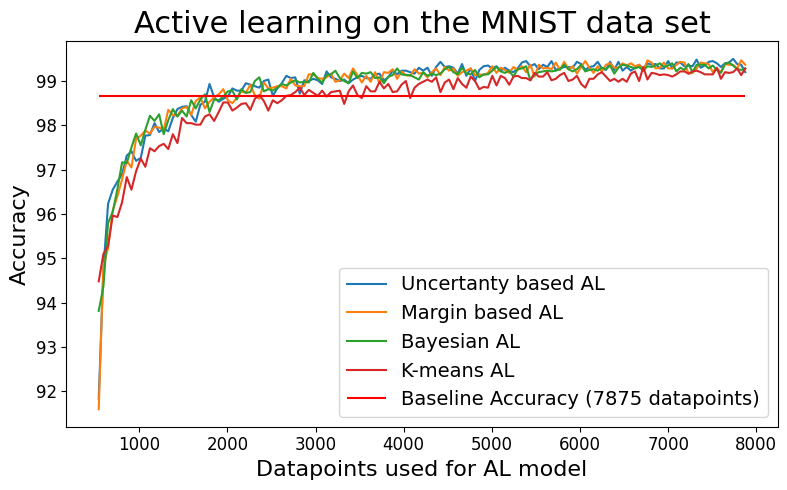

In [19]:
# Plot the accuracy
plt.figure(figsize=(8,5))
plt.plot(US_data.iloc[:,0], US_data.iloc[:,1], label='Uncertanty based AL')
plt.plot(MAR_data.iloc[:,0], MAR_data.iloc[:,1], label='Margin based AL')
plt.plot(BADL_data.iloc[:,0], BADL_data.iloc[:,1], label='Bayesian AL')
plt.plot(KMEANS_data.iloc[:,0], KMEANS_data.iloc[:,1], label='K-means AL')

plt.hlines(max(baseline_accuracy), min(US_data.iloc[:,0]), max(US_data.iloc[:,0]), label=f'Baseline Accuracy ({len(train_dataset)} datapoints)', color='red')
plt.title('Active learning on the MNIST data set', fontsize = 22)
plt.xlabel('Datapoints used for AL model', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.legend(fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.savefig('figs/2_Comparison_3_MNIST.png')
plt.show()